In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import getpass
import psycopg2

ticker = 'MSFT'
start_date = '2023-01-01'
end_date = '2023-12-31'
data = yf.download(ticker, start=start_date, end=end_date, interval='1d')
data.reset_index(inplace=True)  # Reset index to move the date to a column

data.head()


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,243.080002,245.750000,237.399994,239.580002,236.609238,25740000
1,2023-01-04,232.279999,232.869995,225.960007,229.100006,226.259171,50623400
2,2023-01-05,227.199997,227.550003,221.759995,222.309998,219.553375,39585600
3,2023-01-06,223.000000,225.759995,219.350006,224.929993,222.140854,43613600
4,2023-01-09,226.449997,231.240005,226.410004,227.119995,224.303696,27369800


In [3]:
# Step 2: Insert data into PostgreSQL
dbname = "stock_marketsql"
user = "mekhi"
host = "localhost"


password = getpass.getpass('Password for user mekhi: ')
conn = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host
)


cur = conn.cursor()
cur.execute("INSERT INTO Companies (name, ticker_symbol) VALUES ('Microsoft Corp.', 'MSFT') ON CONFLICT DO NOTHING;")
cur.execute("INSERT INTO Markets (name, location) VALUES ('NASDAQ', 'New York') ON CONFLICT DO NOTHING;")
conn.commit()

# Get the company_id and market_id for MSFT and NASDAQ
cur.execute("SELECT id FROM Companies WHERE ticker_symbol = 'MSFT';")
company_id = cur.fetchone()[0]
cur.execute("SELECT id FROM Markets WHERE name = 'NASDAQ';")
market_id = cur.fetchone()[0]

# Insert data into the Stocks table
for index, row in data.iterrows():
    cur.execute("""
        INSERT INTO Stocks (company_id, market_id, date, open_price, high_price, low_price, close_price, volume)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s);
    """, (company_id, market_id, row['Date'], row['Open'], row['High'], row['Low'], row['Close'], row['Volume']))

conn.commit()
cur.close()
conn.close()


Password for user mekhi:  ········


C:\Users\mekhi\AppData\Local\Temp\ipykernel_896\2695317682.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


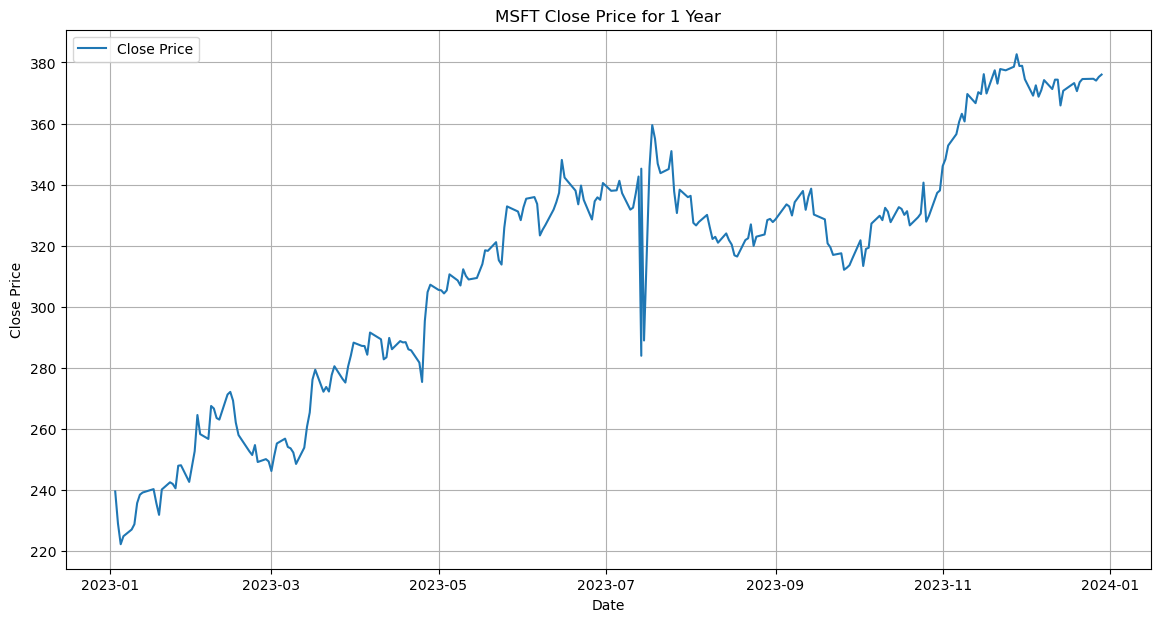

In [5]:
# Step 3: Query data from PostgreSQL and plot
conn = psycopg2.connect(
    dbname=dbname,
    user=user,
    password=password,
    host=host
)

query = """
SELECT date, close_price
FROM Stocks
JOIN Companies ON Stocks.company_id = Companies.id
WHERE Companies.ticker_symbol = 'MSFT'
AND date BETWEEN '2023-01-01' AND '2023-12-31'
ORDER BY date;
"""


df = pd.read_sql_query(query, conn)


conn.close()


plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['close_price'], label='Close Price')
plt.title('MSFT Close Price for 1 Year')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()
